In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr
from scipy.optimize import curve_fit

from iminuit import Minuit
from iminuit.cost import LeastSquares

In [2]:
data = xr.load_dataset('../../input_data/moce5/moce5_dataset.cdf', decode_timedelta=False)
simu_diusst = np.load('../../output_files/simu_diusst.npy', allow_pickle=True)
simu_zb05 = np.load('../../output_files/simu_zb05.npy', allow_pickle=True)
simu_slab = np.load('../../output_files/simu_slab.npy', allow_pickle=True)
simu_const = np.load('../../output_files/simu_const.npy', allow_pickle=True)

T_f = float(data.T_f)
ref_idx = 20
times = data['time_day'].to_numpy()[:-1]
winds = data['wind'].to_numpy()[:-1]

dsst_obs = data['dsst'][:-1]
dsst_diusst = simu_diusst[0][:,0] - simu_diusst[0][:,ref_idx]
dsst_zb05 = simu_zb05[0]
dsst_slab = simu_slab[0] - T_f

print('Reference depth: {:.3f} m'.format(simu_diusst[2][ref_idx]))

Reference depth: -3.045 m


/home/reykiboy/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
dw=.5
u_lower = np.arange(0,10,dw)

times_bin = []
dsst_obs_bin = []
dsst_diusst_bin = []
dsst_zb05_bin = []
dsst_slab_bin = []

for i in range(len(u_lower)):
    times_bin.append(times[(winds>=u_lower[i])*(winds<u_lower[i]+dw)])
    dsst_obs_bin.append(dsst_obs[(winds>=u_lower[i])*(winds<u_lower[i]+dw)])
    dsst_diusst_bin.append(dsst_diusst[(winds>=u_lower[i])*(winds<u_lower[i]+dw)])
    dsst_zb05_bin.append(dsst_zb05[(winds>=u_lower[i])*(winds<u_lower[i]+dw)])
    dsst_slab_bin.append(dsst_slab[(winds>=u_lower[i])*(winds<u_lower[i]+dw)])
    
times_hav = np.arange(0,24)+0.5
times_bin_hav = []
dsst_obs_bin_hav = np.zeros((len(u_lower),24))
dsst_diusst_bin_hav = np.zeros((len(u_lower),24))
dsst_zb05_bin_hav = np.zeros((len(u_lower),24))
dsst_slab_bin_hav = np.zeros((len(u_lower),24))

for i in range(len(u_lower)):
    time_array = (times_bin[i]%1)*24
    for j in range(24):
        dsst_obs_bin_hav[i,j] = np.mean(dsst_obs_bin[i][(time_array>=j)*(time_array<j+1)])
        dsst_diusst_bin_hav[i,j] = np.mean(dsst_diusst_bin[i][(time_array>=j)*(time_array<j+1)])
        dsst_zb05_bin_hav[i,j] = np.mean(dsst_zb05_bin[i][(time_array>=j)*(time_array<j+1)])
        dsst_slab_bin_hav[i,j] = np.mean(dsst_slab_bin[i][(time_array>=j)*(time_array<j+1)])

/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3

In [4]:
def expo(x,a,b):
    return b*np.exp(-x/a)

stop=13

fit_obs = curve_fit(expo, u_lower[:stop]+dw/2, np.nanmax(dsst_obs_bin_hav, axis=1)[:stop], p0=[1,3])[0]
fit_model = curve_fit(expo, u_lower[:stop]+dw/2, np.nanmax(dsst_diusst_bin_hav, axis=1)[:stop], p0=[1,3])[0]
fit_zb05 = curve_fit(expo, u_lower[:stop]+dw/2, np.nanmax(dsst_zb05_bin_hav, axis=1)[:stop], p0=[2,4])[0]
fit_slab = curve_fit(expo, u_lower[:stop]+dw/2, np.nanmax(dsst_slab_bin_hav, axis=1)[:stop], p0=[100,1])[0]

print('=== FIT RESULTS ======================')
print('              Exponent   y intercept')
print('Observations', fit_obs)
print('diuSST      ', fit_model)
print('ZB05        ', fit_zb05)
print('Slab        ', fit_slab)

=== FIT RESULTS ======================
              Exponent   y intercept
Observations [1.98416233 4.5923607 ]
diuSST       [2.08447096 4.11522097]
ZB05         [1.73742444 5.04091154]
Slab         [29.62931136  1.03866911]


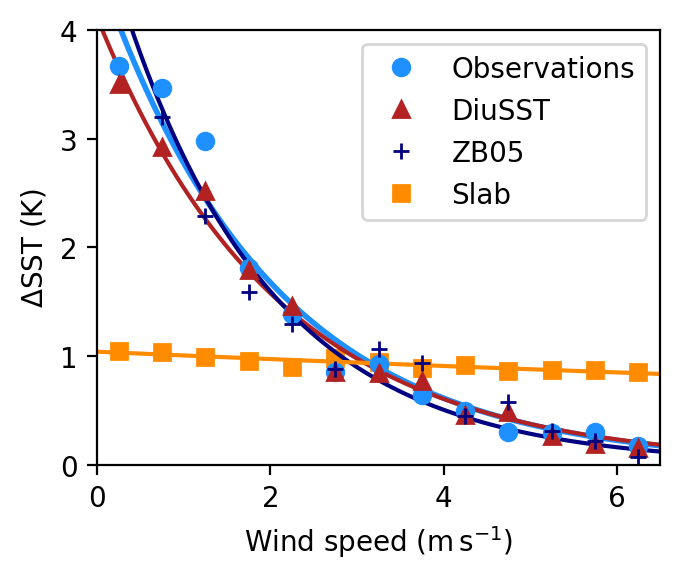

In [5]:
fig, ax = plt.subplots(figsize=(3.5,3.),dpi=200)
xx = np.linspace(0,7,100)
ax.plot(xx,expo(xx,*fit_obs), c='dodgerblue', lw=2)
ax.plot(xx,expo(xx,*fit_model), c='firebrick')
ax.plot(xx,expo(xx,*fit_zb05), c='navy')
ax.plot(xx,expo(xx,*fit_slab), c='darkorange')

ax.plot(u_lower[:stop]+dw/2,np.nanmax(dsst_obs_bin_hav, axis=1)[:stop],'o', c='dodgerblue', label='Observations')
ax.plot(u_lower[:stop]+dw/2,np.nanmax(dsst_diusst_bin_hav, axis=1)[:stop],'^', c='firebrick',label='DiuSST')
ax.plot(u_lower[:stop]+dw/2,np.nanmax(dsst_zb05_bin_hav, axis=1)[:stop],'+', c='navy',label='ZB05')
ax.plot(u_lower[:stop]+dw/2,np.nanmax(dsst_slab_bin_hav, axis=1)[:stop],'s', c='darkorange', label='Slab',zorder=-3)

ax.set_ylim(0.01,4)
ax.set_xlim(0,6.5)
ax.legend()

ax.set(xlabel=r'Wind speed (m$\,$s$^{-1}$)')
ax.set(ylabel='$\Delta$SST (K)')

ax.set_ylim(0.0,4)
ax.set(yticks=[0,1,2,3,4])

plt.tight_layout()

#plt.savefig("fig8_j2.pdf", bbox_inches='tight')

plt.show()